# Parallelized MPC Parameter Tuning

This notebook uses multiprocessing to speed up the grid search for optimal MPC parameters.

In [4]:
# set up
%load_ext autoreload
%autoreload 2
%pip install numpy matplotlib scipy shapely

import numpy as np
import logging
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
plt.rcParams['animation.embed_limit'] = 2**128
from simulator import CrowdSimulator, Agent, SocialForceModel, create_test_scenario
from LeaderFollowerSFM import Leader_Follower_SFM
from mpc_controller import MPCLocalPlanner,RobotMPCController
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Parallelized version - Import additional libraries
from multiprocessing import Pool, cpu_count
import itertools
from functools import partial
import time

In [6]:
import gc
def createAndRunMuseum(the_horizon, the_wg, the_ws, the_wd, the_wps):
    sim = CrowdSimulator(time_step=0.1, max_steps=700)

    sim.add_obstacle((-9.0011,2.9761),(-6.0106,3.0219))
    sim.add_obstacle((-6.0106,3.0219),(-5.9847,5.9228))
    sim.add_obstacle((-5.9847,5.9228),(5.9642,5.9746))
    sim.add_obstacle((5.9642,5.9746),(6.0160,2.9960))
    sim.add_obstacle((6.0160,2.9960),(8.9708,2.9701))
    sim.add_obstacle((8.9708,-3.0299),(5.9708,-3.0299))
    sim.add_obstacle((8.9708,2.9701),(8.9708,-3.0299))
    sim.add_obstacle((5.9708,-3.0299),(6.0378,-5.9880))
    sim.add_obstacle((6.0378,-5.9880),(-5.9706,-6.0128))
    sim.add_obstacle((-5.9706,-6.0128),(-5.9706,-3.0128))
    sim.add_obstacle((-5.9706,-3.0128),(-8.9706,-3.0128))
    sim.add_obstacle((-8.9706,-3.0128),(-9.0499,2.9526))
    sim.add_obstacle((-6.2201,9.1548),(6.0390,9.1372))
    sim.add_obstacle((6.0390,9.1372),(6.0390,12.1372))
    sim.add_obstacle((-9.2201,12.1548),(-6.2201,12.1548))
    sim.add_obstacle((-6.2201,12.1548),(-6.2201,9.1548))
    sim.add_obstacle((6.0390,12.1372),(18.2900,12.1195))
    sim.add_obstacle((18.2900,12.1195),(18.1297,3.0741))
    sim.add_obstacle((18.1297,3.0741),(15.0960,2.9703))
    sim.add_obstacle((15.0960,2.9703),(15.0290,-2.9684))
    sim.add_obstacle((15.0290,-2.9684),(17.9046,-2.9818))
    sim.add_obstacle((17.9046,-2.9818),(17.9046,-11.9818))
    sim.add_obstacle((17.9046,-11.9818),(5.9046,-11.9818))
    sim.add_obstacle((5.9046,-11.9818),(5.9046,-8.9818))
    sim.add_obstacle((5.9046,-8.9818),(-6.0954,-8.9818))
    sim.add_obstacle((-6.0954,-8.9818),(-6.0954,-11.9818))
    sim.add_obstacle((-18.0954,-11.9818),(-18.0954,-2.9818))
    sim.add_obstacle((-6.0954,-11.9818),(-18.0954,-11.9818))
    sim.add_obstacle((-18.0954,-2.9818),(-15.0954,-2.9818))
    sim.add_obstacle((-15.0954,-2.9818),(-15.0954,3.0182))
    sim.add_obstacle((-15.0954,3.0182),(-18.0954,3.0182))
    sim.add_obstacle((-18.0954,3.0182),(-18.0954,12.0182))
    sim.add_obstacle((-18.0954,12.0182),(-12.0939,11.9958))

    robot = sim.add_robot(x=-9.8760, y=10.0338, gx=13.1743, gy=-5.2431, v_pref=1.2, radius=0.3)

    human1 = sim.add_human(x=-9.5975, y=8.6495, gx=[13.4937, 15.0252, 11.5966, -16.0995, -9.5075], gy=[6.3718, -11.1036, -6.1330, -9.0318, 4.6425], v_pref=1.2, wait_times=[3, 0, 0])
    human2 = sim.add_human(x=-15.9231, y=9.7725, gx=[-17.1518, 10.9378, 15.4463, 12.0893, 8.7475], gy=[4.3307, 8.6816, 3.5123, 9.6816, -11.1995], v_pref=1.2, wait_times=[3, 0, 0])
    human3 = sim.add_human(x=-7.7297, y=4.0221, gx=[-5.8386, 17.0300, 9.4484, 17.1624, 7.8081, 17.8895, -18.1262, -15.4962, -9.9727, -10.3212], gy=[7.0011, 7.1234, 0.7271, -5.0536, -3.7833, -7.5665, -9.5330, -3.7409, -0.7120, 4.1486], v_pref=1.2, wait_times=[3, 0, 0])
    human4 = sim.add_human(x=-14.8475, y=9.6742, gx=[-6.7805, -6.8096, -0.4241, 8.4706, 16.6232, 11.3760, 17.2709, 17.2709], gy=[9.9938, 8.4285, 6.3131, 8.2223, 8.8534, -2.9102, -5.6825, -5.6825], v_pref=1.2, wait_times=[3, 0, 0])
    human5 = sim.add_human(x=7.2017, y=6.2867, gx=[14.5262, 13.5472, -11.2761, -12.5184, -17.4305, -10.4282, -11.5062, -14.0152], gy=[1.1105, -8.8833, -8.4428, -11.5089, -11.0890, -4.9810, 0.8495, 8.8865], v_pref=1.2, wait_times=[3, 0, 0])
    human6 = sim.add_human(x=-16.9871, y=6.3513, gx=[-6.5311, -7.5005, 13.0544, 12.9916], gy=[4.9563, 7.1165, 7.3759, -11.4358], v_pref=1.2, wait_times=[3, 0, 0])
    human7 = sim.add_human(x=-16.9452, y=7.6594, gx=[-9.2227, -4.2211, 4.7921, 9.2357, 10.2792, 13.8785, 11.1791], gy=[5.2097, 8.0515, 6.6923, 9.9478, 4.5081, -1.1625, -5.4962], v_pref=1.2, wait_times=[3, 0, 0])
    human8 = sim.add_human(x=-6.6120, y=9.0964, gx=[-5.6766, 8.3352, 6.6576, 15.7605, 9.0191, 18.5453, -14.2072, -17.00, -14.0540, -11.4464], gy=[7.3660, 7.7444, 4.1930, 7.8082, -11.1053, -8.5605, -9.1818, -7.9472, -5.5922, 3.6215], v_pref=1.2, wait_times=[3, 0, 0])
    human9 = sim.add_human(x=-12.0221, y=6.8674, gx=[-9.0297, -15.2075, 4.0934, 9.1041, 7.7675, 14.4238], gy=[3.5471, 7.8095, 7.0326, 5.0892, 3.8589, 2.3609], v_pref=1.2, wait_times=[3, 0, 0])
    human10 = sim.add_human(x=-8.3187, y=8.6501, gx=[2.9063, 13.9074, 9.5121, 9.0486, 12.6136], gy=[6.5986, 5.2103, -11.5043, -7.4777, -1.2827], v_pref=1.2, wait_times=[3, 0, 0])
    human11 = sim.add_human(x=-13.2443, y=4.2467, gx=[-14.5532, 4.7901, 17.2705], gy=[-8.0490, -7.2729, -7.0444], v_pref=1.2, wait_times=[3, 0, 0])
    human12 = sim.add_human(x=-17.4336, y=-3.4740, gx=[-17.6954, -11.7660, 17.4017], gy=[-5.7509, -8.0531, -8.2591], v_pref=1.2, wait_times=[3, 0, 0])
    human13 = sim.add_human(x=7.3835, y=-10.9601, gx=[17.4335, -2.3878, -0.1098, 17.5627], gy=[-7.7541, -6.5981, -8.3249, -3.6588], v_pref=1.2, wait_times=[3, 0, 0])
    human14 = sim.add_human(x=-12.3610, y=8.4369, gx=[1.5751, 14.4533, 10.3304, 16.9712, 13.5599, -10.2435], gy=[6.4883, 6.5129, -3.4738, -7.4037, -8.4330, -7.3130], v_pref=1.2, wait_times=[3, 0, 0])
    human15 = sim.add_human(x=-13.8880, y=-10.5591, gx=[-16.2396, -7.4134, -14.4071, -14.2239], gy=[-5.6726, -3.8708, -2.3743, 2.0235], v_pref=1.2, wait_times=[3, 0, 0])
    human16 = sim.add_human(x=-12.8787, y=8.7648, gx=[0.5397, 14.4839, 11.7963, 14.0258, 5.3218], gy=[6.4174, 8.1010, 0.7103, -9.4902, -7.1691], v_pref=1.2, wait_times=[3, 0, 0])
    human17 = sim.add_human(x=-12.0407, y=9.0477, gx=[-2.6710, 17.6652, 16.2396, 10.4980, 15.6593, 15.7098, 12.8390, -13.2861, -9.5443, -11.3077], gy=[8.3256, 6.6147, 5.3218, -2.6797, -5.5199, -10.9637, -7.9097, -8.2245, -1.4953, 1.3211], v_pref=1.2, wait_times=[3, 0, 0])
    human18 = sim.add_human(x=7.2645, y=4.0151, gx=[12.2155, 11.6701, 7.0291, 17.1913], gy=[3.6121, -11.4236, -10.5341, -9.4941], v_pref=1.2, wait_times=[3, 0, 0])
    human19 = sim.add_human(x=-9.7554, y=6.9553, gx=[2.1242, 15.4012, 10.6351, 8.3847, 6.5963, 17.4636], gy=[7.9572, 6.0448, -1.8925, -4.5973, -10.0535, -5.9637], v_pref=1.2, wait_times=[3, 0, 0])
    human20 = sim.add_human(x=-14.3606, y=5.2866, gx=[11.4882, 11.5177, 10.8404, 17.2736, 12.0313], gy=[9.1078, 4.1533, 0.6675, -11.2585, -7.6452], v_pref=1.2, wait_times=[3, 0, 0])
    human21 = sim.add_human(x=-12.4983, y=3.5239, gx=[-14.0119, -7.2717, -14.7731], gy=[-5.7601, -11.0691, -8.6327], v_pref=1.2, wait_times=[3, 0, 0])
    human22 = sim.add_human(x=-10.6294, y=2.0373, gx=[-11.7919, -16.8940, -8.6452], gy=[-3.9798, -9.5575, -11.1060], v_pref=1.2, wait_times=[3, 0, 0])
    human23 = sim.add_human(x=-10.0987, y=6.0680, gx=[-12.1343, -14.4457, -10.4884, 6.6113, 11.3849], gy=[4.0139, -4.3583, -9.5942, -6.2134, 0.7360], v_pref=1.2, wait_times=[3, 0, 0])
    human24 = sim.add_human(x=-10.8473, y=2.9518, gx=[-14.8636, -3.7479, 17.2490, 9.4551, 12.6767, 15.5269, 6.2832, -9.3991], gy=[-6.4049, -7.4212, -6.5301, -1.8873, 5.1974, 11.0874, 8.1888, 6.5900], v_pref=1.2, wait_times=[3, 0, 0])
    human25 = sim.add_human(x=-15.4995, y=5.6156, gx=[-11.7151, -12.0413, -3.5667, 7.5215, 16.9593], gy=[-0.8057, -9.4129, -6.9932, -8.6505, -9.8882], v_pref=1.2, wait_times=[3, 0, 0])
    human26 = sim.add_human(x=11.9314, y=-5.1816, gx=[7.0910, 3.9251, -12.7796, -16.0933, -11.8506, -7.9112, -11.6157, -14.9335], gy=[-7.9811, -8.8269, -8.1957, -4.5186, -11.0294, -4.8467, -2.4837, 4.1597], v_pref=1.2, wait_times=[3, 0, 0])
    human27 = sim.add_human(x=-15.6029, y=-11.5046, gx=[-17.1557, -16.6449, -13.0252, -8.2162, 17.2695], gy=[-5.8052, -3.8242, -11.8474, -6.0667, -10.2702], v_pref=1.2, wait_times=[3, 0, 0])
    human28 = sim.add_human(x=-14.7894, y=2.3704, gx=[-12.8307, -8.3381, -17.8562], gy=[-3.7710, -11.5013, -11.1861], v_pref=1.2, wait_times=[3, 0, 0])
    human29 = sim.add_human(x=-10.6568, y=7.9269, gx=[-16.2618, -17.0260, -15.8622, -6.6053, -13.8225, -11.7335, -16.2357, -9.8509, -9.1732, -6.5923], gy=[5.3904, 11.1486, 8.4066, 3.8514, 3.9129, -3.3997, -6.7164, -7.8158, -9.1554, -5.4902], v_pref=1.2, wait_times=[3, 0, 0])
    human30 = sim.add_human(x=-15.4018, y=10.1731, gx=[-11.5062, -13.8380, -9.3744, -10.3227, -3.9036], gy=[0.2328, -3.7757, -5.2808, -11.3884, -6.7506], v_pref=1.2, wait_times=[3, 0, 0])
    human31 = sim.add_human(x=-14.6919, y=10.8475, gx=[-12.1890, -14.8729, -16.7032, -16.2488, -10.5076, -7.1186, -10.8947, -6.0992], gy=[4.5949, -4.3908, -4.6435, -10.4700, -11.0231, -4.6294, -6.5390, -7.2186], v_pref=1.2, wait_times=[3, 0, 0])
    human32 = sim.add_human(x=-12.4280, y=10.6346, gx=[-17.2060, -15.2527, -10.8929, -15.3023, -17.3248, -15.0070, -11.6349, -7.3365, -13.2171, -6.7844], gy=[4.9973, 3.8339, -0.3747, -3.9656, -8.8271, -11.5704, -11.7621, -10.2760, -6.0005, -4.2922], v_pref=1.2, wait_times=[3, 0, 0])
    human33 = sim.add_human(x=-12.9212, y=-10.5461, gx=[-15.7855, -10.1488, -13.5322, -13.1242, -14.3783, -11.2951, -11.4807], gy=[-5.0665, -2.8430, 2.6647, 11.2526, 7.3908, 0.7831, -5.2600], v_pref=1.2, wait_times=[3, 0, 0])
    human34 = sim.add_human(x=15.9786, y=10.6447, gx=[12.9676, 11.9179, 14.3448, 11.8433, 8.0982, 6.6289, 14.5841, 11.3401, 9.2945, 11.1063], gy=[5.3102, -2.6754, -8.7339, -10.8063, -11.3858, -4.4993, -3.7870, 0.6941, 5.3681, 10.6595], v_pref=1.2, wait_times=[3, 0, 0])
    human35 = sim.add_human(x=6.7026, y=10.9132, gx=[12.6155, 10.9680, 17.2127, 12.8407, 9.2313, 7.0709, 13.1403, 11.3201, 11.3201], gy=[4.7211, -3.6795, -8.6711, -11.4641, -9.0080, -3.8100, -3.3696, 1.1930, 1.1930], v_pref=1.2, wait_times=[3, 0, 0])
    human36 = sim.add_human(x=6.3604, y=9.2287, gx=[12.3059, 13.8046, 12.0291, 9.6895, 8.5053], gy=[6.8178, -1.1559, -6.1849, -10.8044, -6.0139], v_pref=1.2, wait_times=[3, 0, 0])
    human37 = sim.add_human(x=-15.8880, y=9.0096, gx=[-12.0939, -14.6501, -9.3129, -6.3232, -0.5510, 3.1917, 9.4168, 14.3497, 17.2562, 16.6276, 13.7005, 9.5712, 6.6452, 1.9943, -1.5676, -4.3711, -7.3346], gy=[7.1164, 2.6583, 5.4808, 7.3306, 7.2076, 8.3116, 7.5163, 10.5742, 6.1290, 4.2901, 5.1008, 6.5428, 7.1287, 7.8939, 8.2145, 6.6278, 7.2135], v_pref=1.2, wait_times=[3, 0, 0])
    human38 = sim.add_human(x=-14.2754, y=8.7923, gx=[-16.0204, -6.4353, 2.1798, 9.5003, 14.0356, 15.2226, 11.9502, 8.0149], gy=[4.7746, 7.2552, 8.3069, 5.6807, 5.5894, 8.2177, 10.7503, 10.7695], v_pref=1.2, wait_times=[3, 0, 0])
    human39 = sim.add_human(x=13.8067, y=-10.5719, gx=[17.4264, 4.9529, -3.3951, -16.1855, -14.5515, -11.3558, -8.2893, -6.5209], gy=[-4.8124, -7.6927, -6.4601, -7.5901, -4.3603, -6.5185, -5.0805, -3.6019], v_pref=1.2, wait_times=[3, 0, 0])
    human40 = sim.add_human(x=-17.5712, y=-6.7826, gx=[-15.5428, -15.4738, -14.7498, -12.3275, 1.6768, 11.1363], gy=[-3.7403, -9.4602, -10.4635, -9.8325, -6.4639, -7.6128], v_pref=1.2, wait_times=[3, 0, 0])


    sim.set_human_policy(human1.id, SocialForceModel()) 
    sim.set_human_policy(human2.id, SocialForceModel())
    sim.set_human_policy(human3.id, SocialForceModel()) 
    sim.set_human_policy(human4.id, SocialForceModel())
    sim.set_human_policy(human5.id, SocialForceModel()) 
    sim.set_human_policy(human6.id, SocialForceModel())
    sim.set_human_policy(human7.id, SocialForceModel()) 
    sim.set_human_policy(human8.id, SocialForceModel())
    sim.set_human_policy(human9.id, SocialForceModel()) 
    sim.set_human_policy(human10.id, SocialForceModel())
    sim.set_human_policy(human11.id, SocialForceModel()) 
    sim.set_human_policy(human12.id, SocialForceModel())
    sim.set_human_policy(human13.id, SocialForceModel()) 
    sim.set_human_policy(human14.id, SocialForceModel())
    sim.set_human_policy(human15.id, SocialForceModel()) 
    sim.set_human_policy(human16.id, SocialForceModel())
    sim.set_human_policy(human17.id, SocialForceModel()) 
    sim.set_human_policy(human18.id, SocialForceModel())
    sim.set_human_policy(human19.id, SocialForceModel()) 
    sim.set_human_policy(human20.id, SocialForceModel())
    sim.set_human_policy(human21.id, SocialForceModel()) 
    sim.set_human_policy(human22.id, SocialForceModel())
    sim.set_human_policy(human23.id, SocialForceModel()) 
    sim.set_human_policy(human24.id, SocialForceModel())
    sim.set_human_policy(human25.id, SocialForceModel()) 
    sim.set_human_policy(human26.id, SocialForceModel())
    sim.set_human_policy(human27.id, SocialForceModel()) 
    sim.set_human_policy(human28.id, SocialForceModel())
    sim.set_human_policy(human29.id, SocialForceModel()) 
    sim.set_human_policy(human30.id, SocialForceModel())
    sim.set_human_policy(human31.id, SocialForceModel()) 
    sim.set_human_policy(human32.id, SocialForceModel())
    sim.set_human_policy(human33.id, SocialForceModel()) 
    sim.set_human_policy(human34.id, SocialForceModel())
    sim.set_human_policy(human35.id, SocialForceModel()) 
    sim.set_human_policy(human36.id, SocialForceModel())
    sim.set_human_policy(human37.id, SocialForceModel()) 
    sim.set_human_policy(human38.id, SocialForceModel())
    sim.set_human_policy(human39.id, SocialForceModel()) 
    sim.set_human_policy(human40.id, SocialForceModel())


    # # Set Social Force Model for robot with same parameters
    # sim.set_robot_policy(Leader_Follower_SFM(sim=sim))

    mpc_policy = RobotMPCController(
        horizon=the_horizon,
        dt=sim.time_step,
        max_speed = 1.5,
        use_sm_cost= False, #TODO: Change to run with/without the social momentum cost.
        wg=the_wg,
        ws=the_ws,
        wd=the_wd,
        wps=the_wps
    )
    sim.set_robot_policy(mpc_policy)



    for step in range(sim.max_steps):
        print(step)
        _, reward, done, info = sim.step()
        if done:
            break
    #print(sim.calculate_metrics()["robot"])
    # sim.visualize_simulation(show_plot=True, output_file="MuseumMPC_trial_1537.mp4")

    metrics = sim.calculate_metrics()["robot"]


    # try to save your memory
    for agent in sim.all_agents:
        agent.position_history.clear()
        agent.velocity_history.clear()
    sim.all_agents.clear()
    sim.humans.clear()
    sim.obstacles.clear()
    sim.groups.clear()
    sim.human_policies.clear()
    sim.leader_ID.clear()
    del sim
    gc.collect()


    return metrics





In [7]:
# Wrapper function to run multiple simulations for a single parameter set
def evaluate_params(params):
    """
    Run multiple simulations for a single parameter combination.
    Returns: (params, reward, metrics_summary)
    """
    the_horizon, the_wg, the_ws, the_wd, the_wps = params
    
    # Run the simulation multiple times
    all_metrics = []
    num_sim_runs = 5
    
    for i in range(num_sim_runs):
        all_metrics.append(createAndRunMuseum(the_horizon, the_wg, the_ws, the_wd, the_wps))
    
    # Calculate average metrics
    all_time_to_goal = 0
    all_human_dist = 0
    num_collisions = 0
    successful_runs = 0
    
    for metric in all_metrics:
        if metric["time_to_goal"] != 700:  # successful run
            all_time_to_goal += metric["time_to_goal"]
            successful_runs += 1
        
        all_human_dist += metric["min_human_dist"]
        if metric["collision"]:
            num_collisions += 1
    
    # Calculate final metrics
    if successful_runs != 0:
        average_time_to_goal = all_time_to_goal / successful_runs
    else:
        average_time_to_goal = 700
    
    average_min_human_dist = all_human_dist / num_sim_runs
    completion_rate = successful_runs / num_sim_runs
    
    # Calculate reward
    reward = 60*(completion_rate) + 20*(1 - (average_time_to_goal / 700)) + 20 * min(average_min_human_dist / 3.0, 1)
    
    metrics_summary = {
        "completion_rate": completion_rate,
        "avg_time_to_goal": average_time_to_goal,
        "avg_min_human_dist": average_min_human_dist,
        "num_collisions": num_collisions
    }
    
    return (params, reward, metrics_summary)

In [ ]:
# Parallelized Grid Search
def run_parallel_grid_search(num_workers=None, log_file="MPC_parallel_search_log.txt"):
    """
    Run parallelized grid search for MPC parameters.
    
    Args:
        num_workers: Number of parallel processes. If None, uses cpu_count()-1
        log_file: Path to log file for progress tracking
    """
    if num_workers is None:
        num_workers = max(1, cpu_count() - 1)  # Leave one core free
    
    # Define parameter ranges
    horizon_range = range(5, 20, 5)  # 5, 10, 15
    wg_range = np.arange(1, 42, 10)  # 1, 11, 21, 31, 41
    ws_range = np.arange(1, 4, 1)    # 1, 2, 3
    wd_range = np.arange(1, 4, 1)    # 1, 2, 3
    wps_range = np.arange(0, 4, 1)   # 0, 1, 2, 3
    
    # Generate all parameter combinations
    param_combinations = list(itertools.product(
        horizon_range, wg_range, ws_range, wd_range, wps_range
    ))
    
    total_combinations = len(param_combinations)
    
    # Initialize log file
    with open(log_file, "w") as f:
        f.write(f"{'='*60}\n")
        f.write(f"MPC PARAMETER TUNING - PARALLEL GRID SEARCH\n")
        f.write(f"{'='*60}\n")
        f.write(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Workers: {num_workers}\n")
        f.write(f"Available CPUs: {cpu_count()}\n")
        f.write(f"Total parameter combinations: {total_combinations}\n")
        f.write(f"Simulations per combination: 5\n")
        f.write(f"Total simulations: {total_combinations * 5}\n")
        f.write(f"{'='*60}\n\n")
    
    # Track best parameters
    best_params = {"horizon": 8, "wg": 1.0, "ws": 1.0, "wd": 1.0, "wps": 0.0}
    best_reward = 0
    
    start_time = time.time()
    
    # Run parallel evaluation
    with Pool(processes=num_workers) as pool:
        # Use imap_unordered for progress tracking
        results = []
        for i, result in enumerate(pool.imap_unordered(evaluate_params, param_combinations)):
            results.append(result)
            params, reward, metrics = result
            
            # Log each result
            with open(log_file, "a") as f:
                f.write(f"Combination {i+1}/{total_combinations}: ")
                f.write(f"horizon={params[0]}, wg={params[1]}, ws={params[2]}, wd={params[3]}, wps={params[4]} | ")
                f.write(f"Reward={reward:.2f} | ")
                f.write(f"CompRate={metrics['completion_rate']:.2f}, ")
                f.write(f"AvgTime={metrics['avg_time_to_goal']:.1f}, ")
                f.write(f"AvgDist={metrics['avg_min_human_dist']:.3f}\n")
            
            # Update best parameters
            if reward > best_reward:
                best_reward = reward
                best_params = {
                    "horizon": params[0],
                    "wg": params[1],
                    "ws": params[2],
                    "wd": params[3],
                    "wps": params[4]
                }
                
                # Save best parameters to separate file
                with open("MPC_Controller_Values.txt", "w") as file:
                    file.write(f"best_reward={best_reward}\n")
                    file.write(f"best horizon={best_params['horizon']}\n")
                    file.write(f"best wg={best_params['wg']}\n")
                    file.write(f"best ws={best_params['ws']}\n")
                    file.write(f"best wd={best_params['wd']}\n")
                    file.write(f"best wps={best_params['wps']}\n")
                    file.write(f"\nBest metrics:\n")
                    file.write(f"  completion_rate={metrics['completion_rate']}\n")
                    file.write(f"  avg_time_to_goal={metrics['avg_time_to_goal']}\n")
                    file.write(f"  avg_min_human_dist={metrics['avg_min_human_dist']}\n")
                
                # Log new best to log file
                with open(log_file, "a") as f:
                    f.write(f"*** NEW BEST! Reward={best_reward:.2f} ***\n")
            
            # Progress update to log file
            if (i + 1) % 10 == 0 or (i + 1) == total_combinations:
                elapsed = time.time() - start_time
                progress = (i + 1) / total_combinations * 100
                eta = elapsed / (i + 1) * (total_combinations - i - 1)
                
                with open(log_file, "a") as f:
                    f.write(f"\n--- Progress: {i+1}/{total_combinations} ({progress:.1f}%) | ")
                    f.write(f"Elapsed: {elapsed/60:.1f}min | ETA: {eta/60:.1f}min | ")
                    f.write(f"Best reward: {best_reward:.2f} ---\n\n")
    
    total_time = time.time() - start_time
    
    # Final summary to log file
    with open(log_file, "a") as f:
        f.write(f"\n{'='*60}\n")
        f.write(f"GRID SEARCH COMPLETE!\n")
        f.write(f"{'='*60}\n")
        f.write(f"End time: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)\n")
        f.write(f"\nBest parameters found:\n")
        f.write(f"  Horizon: {best_params['horizon']}\n")
        f.write(f"  wg: {best_params['wg']}\n")
        f.write(f"  ws: {best_params['ws']}\n")
        f.write(f"  wd: {best_params['wd']}\n")
        f.write(f"  wps: {best_params['wps']}\n")
        f.write(f"  Best Reward: {best_reward:.2f}\n")
        f.write(f"{'='*60}\n")
    
    return best_params, best_reward, results

In [ ]:
# Run the parallelized grid search
# Adjust num_workers based on your CPU (None = auto-detect and use all but 1 core)
%%capture
best_params, best_reward, all_results = run_parallel_grid_search(num_workers=5)  # Change 4 to your preferred number

Starting parallel grid search with 5 workers...
Available CPUs: 24
Total parameter combinations to test: 540
Each combination runs 5 simulations
Total simulations: 2700
MPC Controller initialized with Horizon=5, Timestep=0.1MPC Controller initialized with Horizon=5, Timestep=0.1MPC Controller initialized with Horizon=5, Timestep=0.1MPC Controller initialized with Horizon=5, Timestep=0.1

MPC Controller initialized with Horizon=5, Timestep=0.1

00
0
0

0

MPC Controller initialized with Horizon=5, Timestep=0.1MPC Controller initialized with Horizon=5, Timestep=0.1MPC Controller initialized with Horizon=5, Timestep=0.1MPC Controller initialized with Horizon=5, Timestep=0.1

MPC Controller initialized with Horizon=5, Timestep=0.1

00
0
0

0

1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
3
3
2
2
43

43

3
3
3
3
3
3
5
5
4
4
4
4
4
4
6
6
4
4
5
5
7
7
5
5
5
5
6
6
5
5
6
6
8
8
6
6
7
7
7
7
7
6
7
6
9
9
8
8
8
8
7
10
7
10
8
8
9
9
9
9
9
9
10
8
10
8
11
11
10
10
11
11
9
9
10
10
12
12
12
11
12
11
10
10
11
11
13
13

Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:


KeyboardInterrupt: 

MPC Controller initialized with Horizon=2, Timestep=0.1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
26

2025-12-06 15:38:10,634 - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-12-06 15:38:10,634 - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x1000 -pix_fmt rgba -framerate 12 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y MuseumMPC_trial_1537.mp4


{'time_to_goal': 333, 'collision': False, 'path_efficiency': np.float64(1.6217364675517976), 'avg_speed': np.float64(1.331176374886632), 'path_smoothness': np.float64(0.6301861523892529), 'change_in_human_acc': 847, 'min_human_dist': np.float64(0.9633653259689735)}
THIS IS FRAME:  0
0
THIS IS FRAME:  0
0
Saving animation to MuseumMPC_trial_1537.mp4...
THIS IS FRAME:  0
0
THIS IS FRAME:  0
0
THIS IS FRAME:  1
0
THIS IS FRAME:  2
0
THIS IS FRAME:  3
0
THIS IS FRAME:  4
0
THIS IS FRAME:  5
0
THIS IS FRAME:  6
0
THIS IS FRAME:  7
0
THIS IS FRAME:  8
0
THIS IS FRAME:  9
0
THIS IS FRAME:  10
0
THIS IS FRAME:  11
0
THIS IS FRAME:  12
0
THIS IS FRAME:  13
0
THIS IS FRAME:  14
0
THIS IS FRAME:  15
0
THIS IS FRAME:  16
0
THIS IS FRAME:  17
0
THIS IS FRAME:  18
0
THIS IS FRAME:  19
0
THIS IS FRAME:  20
0
THIS IS FRAME:  21
0
THIS IS FRAME:  22
0
THIS IS FRAME:  23
0
THIS IS FRAME:  24
0
THIS IS FRAME:  25
0
THIS IS FRAME:  26
0
THIS IS FRAME:  27
0
THIS IS FRAME:  28
0
THIS IS FRAME:  29
0
THIS I

2025-12-06 15:38:31,369 - INFO - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


THIS IS FRAME:  333
0
Save complete.
THIS IS FRAME:  0
0
THIS IS FRAME:  0
0
THIS IS FRAME:  1
0
THIS IS FRAME:  2
0
THIS IS FRAME:  3
0
THIS IS FRAME:  4
0
THIS IS FRAME:  5
0
THIS IS FRAME:  6
0
THIS IS FRAME:  7
0
THIS IS FRAME:  8
0
THIS IS FRAME:  9
0
THIS IS FRAME:  10
0
THIS IS FRAME:  11
0
THIS IS FRAME:  12
0
THIS IS FRAME:  13
0
THIS IS FRAME:  14
0
THIS IS FRAME:  15
0
THIS IS FRAME:  16
0
THIS IS FRAME:  17
0
THIS IS FRAME:  18
0
THIS IS FRAME:  19
0
THIS IS FRAME:  20
0
THIS IS FRAME:  21
0
THIS IS FRAME:  22
0
THIS IS FRAME:  23
0
THIS IS FRAME:  24
0
THIS IS FRAME:  25
0
THIS IS FRAME:  26
0
THIS IS FRAME:  27
0
THIS IS FRAME:  28
0
THIS IS FRAME:  29
0
THIS IS FRAME:  30
0
THIS IS FRAME:  31
0
THIS IS FRAME:  32
0
THIS IS FRAME:  33
0
THIS IS FRAME:  34
0
THIS IS FRAME:  35
0
THIS IS FRAME:  36
0
THIS IS FRAME:  37
0
THIS IS FRAME:  38
0
THIS IS FRAME:  39
0
THIS IS FRAME:  40
0
THIS IS FRAME:  41
0
THIS IS FRAME:  42
0
THIS IS FRAME:  43
0
THIS IS FRAME:  44
0
THIS IS 

{'time_to_goal': 333,
 'collision': False,
 'path_efficiency': np.float64(1.6217364675517976),
 'avg_speed': np.float64(1.331176374886632),
 'path_smoothness': np.float64(0.6301861523892529),
 'change_in_human_acc': 847,
 'min_human_dist': np.float64(0.9633653259689735)}

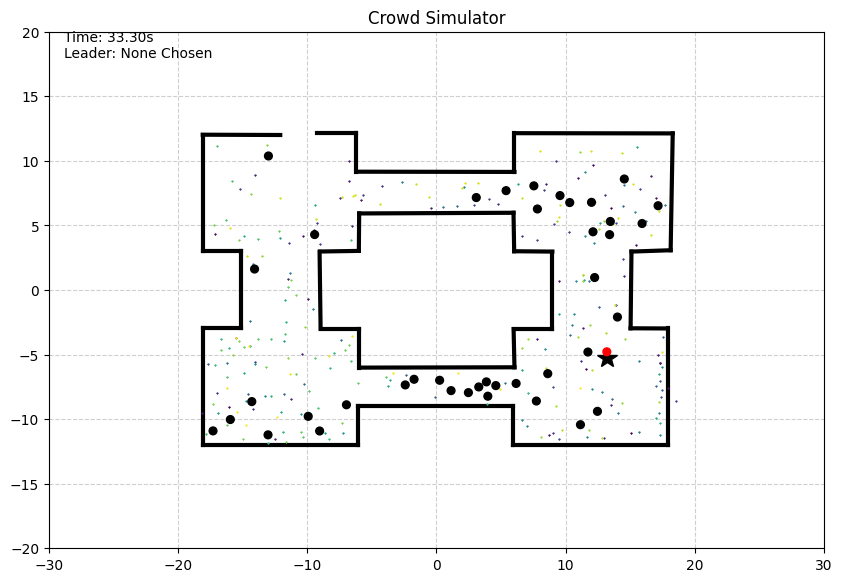

In [3]:
createAndRunMuseum(2, 41, 1.0, 2.0, 0.0)

In [ ]:
%%capture

best_params = {"horizon":8, "wg":1.0, "ws":1.0, "wd":1.0, "wps":0.0} # using the initial parameters given
best_weight = 0 # because we assume it's bad

# iterate through every possible combination of parameters and find the one with the best weight
for the_horizon in range(5, 20, 5): # 8, 13, 18
    for the_wg in np.arange(1, 42, 10): # 11, 21, 31, 41
        for the_ws in np.arange(1, 4, 1): # 1, 2, 3
            for the_wd in np.arange(1, 4, 1): # 1, 2, 3
                for the_wps in np.arange(0, 4, 1): # 0, 1, 2, 3
                    # run the simulation 10 times
                    all_metrics = []
                    num_sim_runs = 5
                    for i in range(0, num_sim_runs, 1):
                        all_metrics.append(createAndRunMuseum(the_horizon, the_wg, the_ws, the_wd, the_wps))
                    
                    # now get the averages for each metric
                    all_time_to_goal = 0
                    all_human_dist = 0
                    num_collisions = 0
                    all_path_smoothness = 0
                    all_impulses = 0
                    successful_runs = 0
                    for metric in all_metrics:
                        if(metric["time_to_goal"] != 700): # only add to these if the run was successful
                            all_time_to_goal += metric["time_to_goal"]
                            successful_runs += 1

                        all_human_dist += metric["min_human_dist"]
                        if(metric["collision"]):
                            num_collisions += 1
                        all_path_smoothness += metric["path_smoothness"]

                    # get your parameters
                    if successful_runs !=0:
                        average_time_to_goal = all_time_to_goal / successful_runs
                    else:
                        average_time_to_goal = 700
                    average_min_human_dist = all_human_dist / num_sim_runs
                    completion_rate = successful_runs / num_sim_runs

                    # determine the reward
                    reward = 60*(completion_rate) + 20*(1 - (average_time_to_goal / 700)) + 20* min(average_min_human_dist / 3.0, 1)

                    # is it the best reward so far?
                    if(reward > best_weight):
                        best_weight = reward
                        best_params["horizon"] = the_horizon
                        best_params["wd"] = the_wd
                        best_params["wg"] = the_wg
                        best_params["wps"] = the_wps
                        best_params["ws"] = the_ws

                    # save this all to a file
                    with open("MPC_Controller_Values_parallel.txt", "w") as file:
                        file.write(f"best_weight={best_weight}\n")
                        file.write(f"best horizon={best_params['horizon']}\n")
                        file.write(f"best wd={best_params['wd']}\n")
                        file.write(f"best wg={best_params['wg']}\n")
                        file.write(f"best wps={best_params['wps']}\n")
                        file.write(f"best ws={best_params['ws']}\n")
                        file.write("\n")
                        file.write(f"current horizon={the_horizon}\n")
                        file.write(f"current wd={the_wd}\n")
                        file.write(f"current wg={the_wg}\n")
                        file.write(f"current wps={the_wps}\n")
                        file.write(f"current ws={the_ws}\n")

                        









                    